In [54]:
import pandas as pd 
import sklearn
import numpy as np
import umap.umap_ as umap
from sklearn import manifold
import matplotlib.pyplot as plt
import create_dist_mat as cdm
import seaborn as sb
import retrieve_fuzcav_vector as rfv
import sklearn
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics.pairwise import manhattan_distance
from matplotlib.ticker import FuncFormatter
import scipy.stats
sb.color_palette("light:b")

pd.set_option('display.max_colwidth', None)

In [55]:
# Read in labels for estrogen receptors generated by scripts in EstrogenReceptorComparison/scripts
# folder.
with open("../EstrogenReceptorsComparison/labels.txt") as f:
    # Read in labels file.
    labels = f.readlines()

    # Split pdb file to label.
    labels = [x.split() for x in labels]

    # Print out labels.

    # Close file.
    f.close()


# Create a dictionary of this information.

df_proteins = pd.DataFrame()
df_proteins["File Name"] = [row[0] for row in labels]
df_proteins["Protein Type"] = [row[1] for row in labels]

# Delete the labels variable after reading into a dataframe.
del labels

# Create a dictionary mapping protein type to a color.
dict_color_labels = {'kinome' : "lightblue", "estrogen": "coral"}

# Map protein type to a color.
df_proteins["color"] = df_proteins["Protein Type"].map(dict_color_labels)

# Create ids based of file names.
df_proteins["id"] = [x[:4] for x in df_proteins["File Name"]]

# Create a dictionary mapping protein id to a particular conformation (DFGin vs. DFGinter vs. DFGout).
conformations = {}
confs = pd.read_csv("../paper_data/pdbs.csv")


# Cleanup of data.
confs = confs[["10_PDB_validation", "11_Conformational_state"]]
confs = confs.dropna(axis = 0, subset=["10_PDB_validation"])
confs["id"] = [x[:4] for x in confs["10_PDB_validation"]]
del confs["10_PDB_validation"]
confs["conformation"] = confs["11_Conformational_state"]
del confs["11_Conformational_state"]

# Merge the two dataframes and delete confs.
df_proteins = pd.merge(df_proteins, confs, on="id", how = "outer")
del confs

# Now add the estrogen receptor type into the conformation column.
estr_receptor_data = pd.read_excel("../EstrogenReceptorsComparison/EstrogenReceptors2.xlsx", header = 1)

estr_receptor_data = estr_receptor_data[["PDB code","Agonist/Antagonist", "Alpha/Beta"]]
estr_receptor_data["Ligand Type"] = estr_receptor_data["Agonist/Antagonist"]
del estr_receptor_data["Agonist/Antagonist"]

estr_receptor_data["conformation"] = estr_receptor_data["Alpha/Beta"]
estr_receptor_data["id"] = estr_receptor_data["PDB code"]
del estr_receptor_data["PDB code"]
del estr_receptor_data["Alpha/Beta"]

df_proteins = pd.merge(df_proteins, estr_receptor_data, on=["id"], how = "left")
confos = df_proteins["conformation_x"].combine_first(df_proteins["conformation_y"])
df_proteins["conformation"] = confos
del df_proteins["conformation_x"]
del df_proteins["conformation_y"]
df_proteins["new_lab"] = df_proteins["Protein Type"] + " - " + df_proteins["conformation"]
map_lab = dict(zip(df_proteins["id"], df_proteins["new_lab"]))




In [75]:

print(df_proteins)
palette = {"estrogen - Alpha": "gold", "estrogen - Beta":"orange", "estrogen - NA":"black", "kinome - DFGin":"royalblue", 
           "kinome - DFGinter":"lightblue", "kinome - DFGout":"violet", "kinome - NA":"black"}# Plotting functions
def no_labels(x, pos):
    """Returns empty string for tick labels"""
    return ""

def plot_umap(ax, vectors, labels, map_lab = map_lab, palette = palette, metric_plot = 'manhattan'):
    vectors = np.array(vectors)
    reducer = umap.UMAP(metric=metric_plot)
    embedding = reducer.fit_transform(vectors)
    colors = [palette.get(map_lab[lab], "black") for lab in labels]
    ax.scatter(embedding[:, 0], embedding[:, 1], alpha = 0.8, color = colors)
    ax.xaxis.set_major_formatter(FuncFormatter(no_labels))
    ax.yaxis.set_major_formatter(FuncFormatter(no_labels))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])


def plot_pca(ax, vectors, labels, map_lab=map_lab, palette = palette, n_components=2):
    # Standardizing the features
    vectors = StandardScaler().fit_transform(np.array(vectors))
    
    # Initialize PCA and reduce to specified number of principal components
    pca = PCA(n_components=n_components)
    embedding = pca.fit_transform(vectors)
    

    explained_variance_ratio = pca.explained_variance_ratio_

    variance_one = (explained_variance_ratio[0] * 100).round(2)
    variance_two = (explained_variance_ratio[1] * 100).round(2)

    ax.set_xlabel(f"{variance_one:0.2f}% variance explained")
    ax.set_ylabel(f"{variance_two:0.2f}% variance explained")
    # Map labels to colors using the provided palette and map_lab dictionary
    colors = [palette.get(map_lab[lab], "black") for lab in labels]
    
    # Scatter plot on the given axes
    ax.scatter(embedding[:, 0], embedding[:, 1], alpha=0.8, color=colors)

    # Removing labels and ticks on the axes
    no_labels = lambda x, pos: ""
    ax.xaxis.set_major_formatter(FuncFormatter(no_labels))
    ax.yaxis.set_major_formatter(FuncFormatter(no_labels))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    

  

               File Name Protein Type      color    id Ligand Type  \
0    6B8Y_A_aligned.mol2       kinome  lightblue  6B8Y         NaN   
1    6NO9_A_aligned.mol2       kinome  lightblue  6NO9         NaN   
2    3DAK_D_aligned.mol2       kinome  lightblue  3DAK         NaN   
3    6C0T_A_aligned.mol2       kinome  lightblue  6C0T         NaN   
4    2C47_D_aligned.mol2       kinome  lightblue  2C47         NaN   
..                   ...          ...        ...   ...         ...   
311             2i0g.pdb     estrogen      coral  2i0g  Antagonist   
312             1x7r.pdb     estrogen      coral  1x7r         NaN   
313             2giu.pdb     estrogen      coral  2giu  Antagonist   
314             2p15.pdb     estrogen      coral  2p15     Agonist   
315             5ak2.pdb     estrogen      coral  5ak2    Mixed/NA   

    conformation           new_lab  
0          DFGin    kinome - DFGin  
1          DFGin    kinome - DFGin  
2          DFGin    kinome - DFGin  
3          

In [76]:
scores = ["3", "5", "7", "9"]
methods = ["Fuzcav", "Zernike", "TMAlign"]



labels_list = []
vectors_list = []
index = 0
for i in scores:
    labels, vectors = rfv.retrieve_fuzcav_vector(f"../../fcav_pipe/pipeline/individual_ligand/{i}A_scores.txt")
    labels = [lab[0:4] for lab in labels]
    labels_list.append(labels)
    vectors_list.append(vectors)
    print("Fuzcav", i)
    index += 1

    labels, vectors = rfv.read_zernike(f"../Zernike/{i}A_3dzds")
    labels_list.append(labels)
    vectors_list.append(vectors)
    print("Zernike", i)
    index += 1

    labels, dist_mat = rfv.read_tm_align(f"../TMAlign/labeled_distance_matrix_{i}A.txt")
    labels_list.append(labels)
    vectors_list.append(dist_mat)
    index += 1
    
    print("tm", i)








Fuzcav 3
Zernike 3
tm 3
Fuzcav 5
Zernike 5
tm 5
Fuzcav 7
Zernike 7
tm 7
Fuzcav 9
Zernike 9
tm 9


Fuzcav 3
Zernike 3
TMAlign 3


/Users/andrewlutsky/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Fuzcav 5
Zernike 5
TMAlign 5


/Users/andrewlutsky/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Fuzcav 7
Zernike 7
TMAlign 7


/Users/andrewlutsky/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Fuzcav 9
Zernike 9
TMAlign 9


/Users/andrewlutsky/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


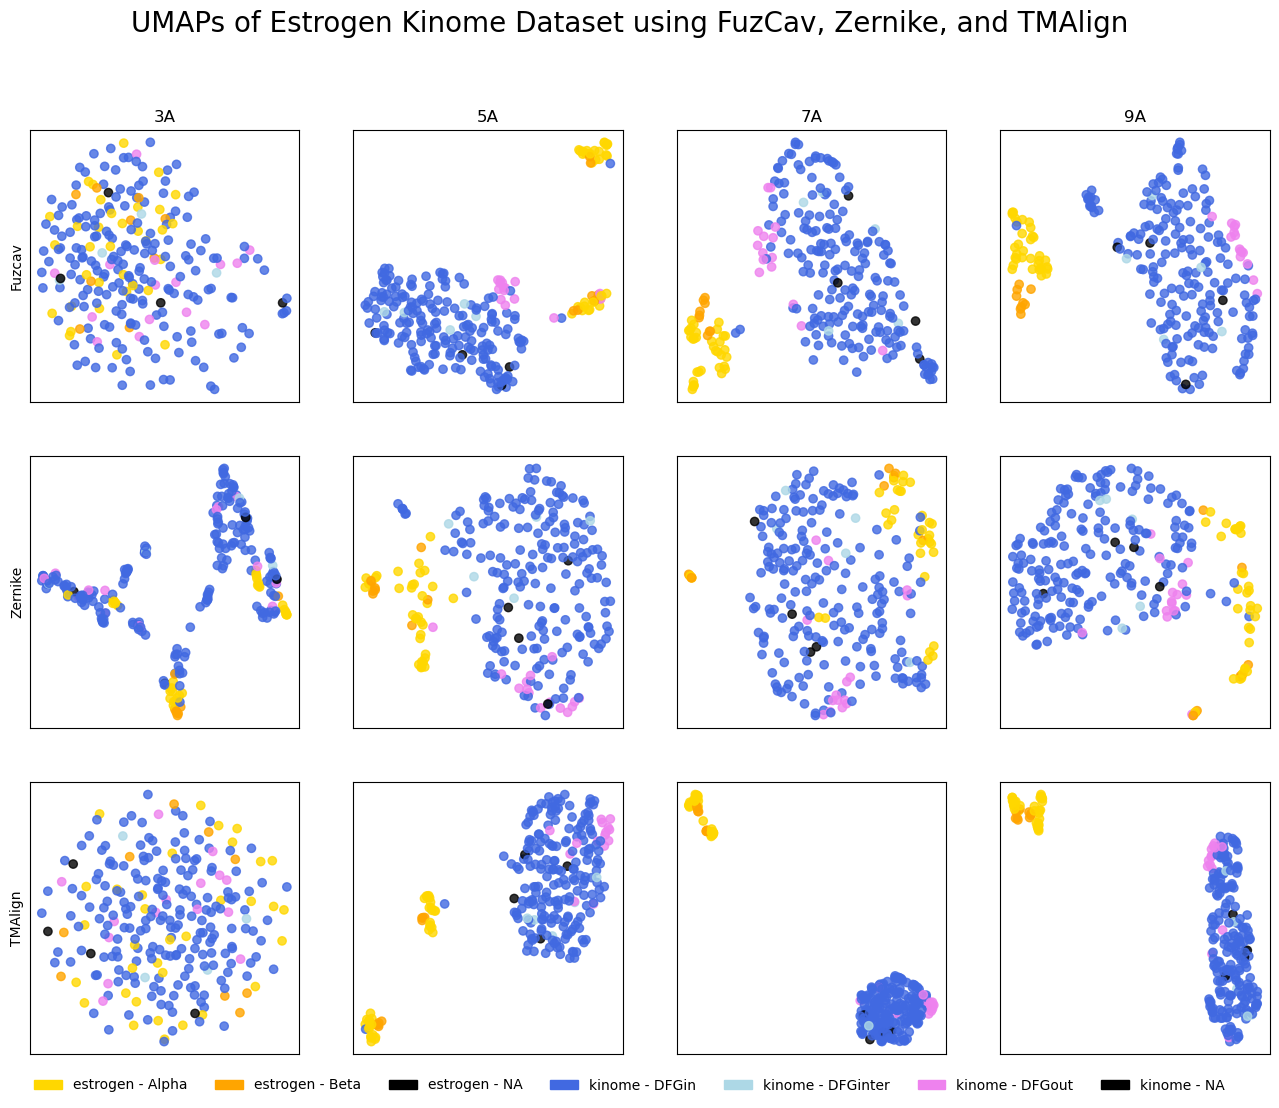

In [65]:
fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (16,12))

fig.suptitle("UMAPs of Estrogen Kinome Dataset using FuzCav, Zernike, and TMAlign", fontsize = 20)
score_names = ["3A", "5A", "7A", "9A"]

for i in range(0, 4):
    axs[0, i].set_title(score_names[i])

for j in range(0, 3):
    axs[j, 0].set_ylabel(methods[j], rotation = 90)



for i, _ in enumerate(scores):
    for j, _ in enumerate(methods):
        #print(j, i)
        print(methods[j], scores[i])
        if methods[j] == "TMAlign":
            try:
                plot_umap(ax = axs[j, i], 
                      metric_plot = "precomputed",
                      vectors = vectors_list[i * len(methods) + j],
                      labels = labels_list[i * len(methods) + j],
                      palette = palette)
            except:
                print(len(vectors_list[i * len(methods) + j]), len(vectors_list[i * len(methods) + j][0]))
            
        else:
           plot_umap(ax = axs[j, i], 
                      metric_plot = "manhattan",
                      vectors = vectors_list[i * len(methods) + j],
                      labels = labels_list[i * len(methods) + j],
                      palette = palette) 

patches = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]
fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 0.1), framealpha = 0.0, ncol=len(palette))

#plt.tight_layout()
plt.savefig("test.png", dpi = 400)
plt.show()


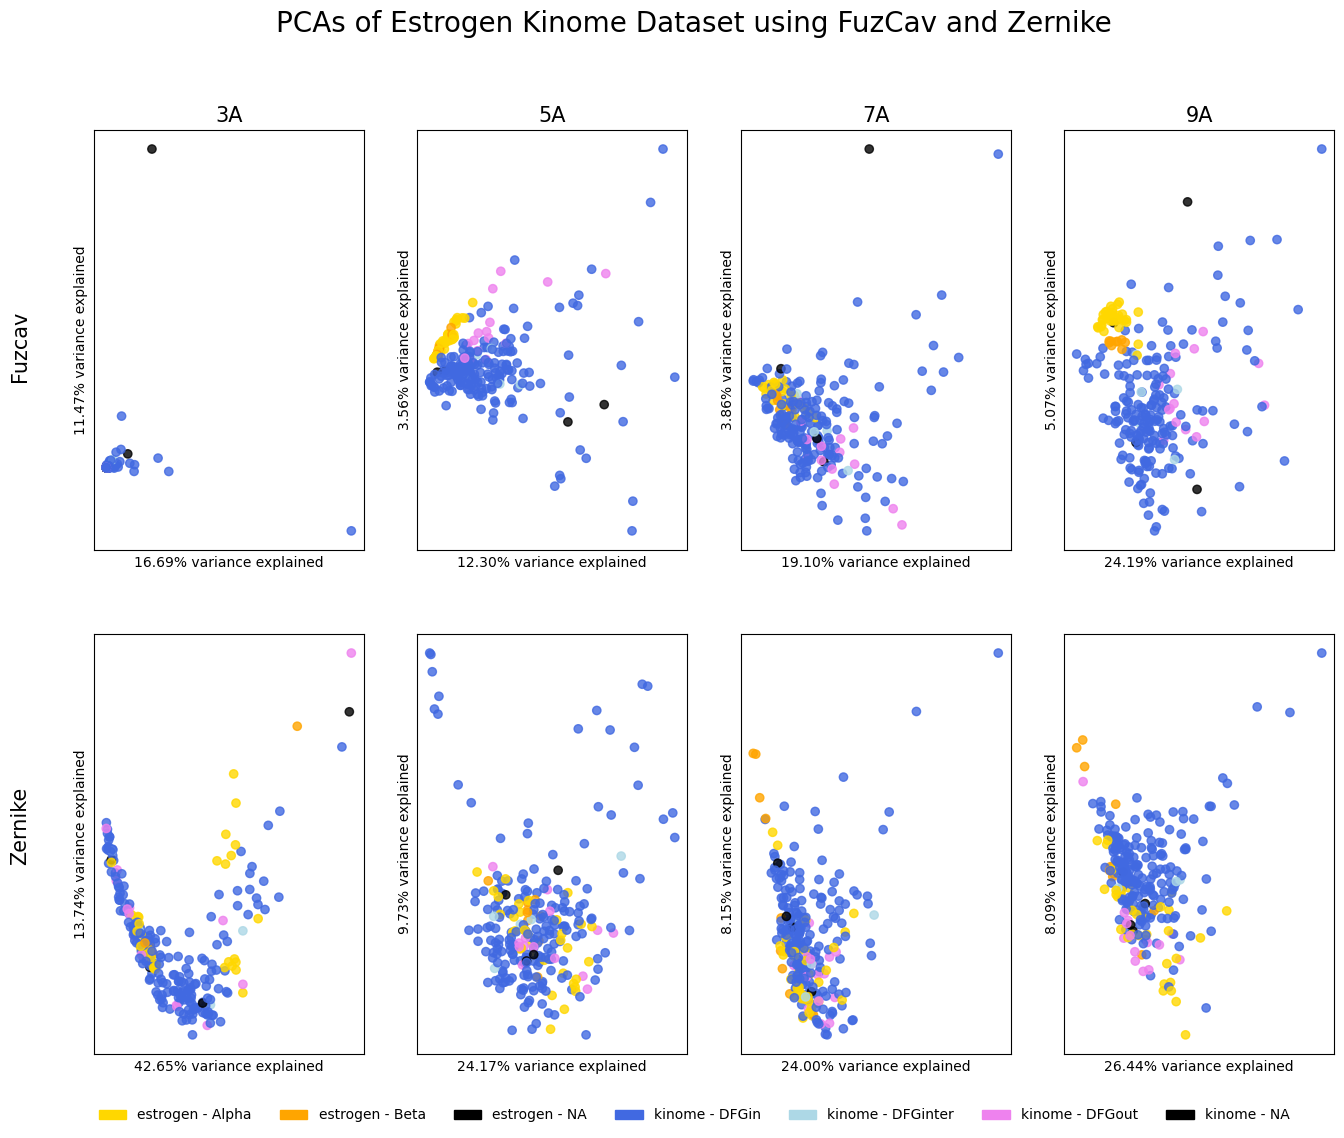

In [89]:
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (16,12))
fig.suptitle("PCAs of Estrogen Kinome Dataset using FuzCav and Zernike", fontsize = 20)
score_names = ["3A", "5A", "7A", "9A"]

for i in range(0, 4):
    axs[0, i].set_title(score_names[i], fontsize=15)

#for j in range(0, 2):
#     axs[j, 0].set_ylabel(methods[j], rotation = 90)


for i, _ in enumerate(scores):
    for j, _ in enumerate(methods[:-1]):
        plot_pca(ax = axs[j,i],
                 vectors = vectors_list[i * len(methods) + j],
                 labels = labels_list[i * len(methods) + j],
                 palette = palette)
        
        
patches = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]
fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 0.075), framealpha = 0.0, ncol=len(palette))
# Add a text for each row
text_y=[0.45, 0.05]
for idx, title in enumerate(methods[0:2]):

    fig.text(0.085, text_y[idx] + 0.25, title, va='center', ha='right', rotation='vertical', fontsize=15)

#plt.tight_layout()
plt.savefig("test_pca.png", dpi = 600)
plt.show()

Spearman Correlation Coefficient

In [ ]:
d

In [ ]:
def spearman_correlation_and_plot(x, y):
    """
    This function calculates the Spearman correlation coefficient for two sets of data
    and creates a scatter plot showing the data points and the correlation coefficient.

    Parameters:
    x (list): A list of x-values.
    y (list): A list of y-values.

    Returns:
    float: The Spearman correlation coefficient.
    """
    # Calculate the Spearman correlation coefficient
    spearman_corr, _ = scipy.stats.spearmanr(x, y)

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', edgecolors='k')
    plt.title(f'Scatter Plot with Spearman Correlation Coefficient = {spearman_corr:.2f}')
    plt.xlabel('FuzCav Distance')
    plt.ylabel('Zernike Distance')

    # Annotate the Spearman correlation coefficient on the plot
    plt.text(0.05, 0.95, f'Spearman Correlation: {spearman_corr:.2f}', 
             ha='left', va='top', transform=plt.gca().transAxes)

    plt.grid(True)
    plt.show()

    return spearman_corr



spearman_correlation_and_plot(x, y)